In [466]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [467]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/


In [468]:
data_flag = 'pneumoniamnist'
# data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 1
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [469]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/caesar/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/caesar/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/caesar/.medmnist/pneumoniamnist.npz


In [470]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /home/caesar/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 624
    Root location: /home/caesar/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}

In [471]:
# visualization
train_dataset.montage(length=1)

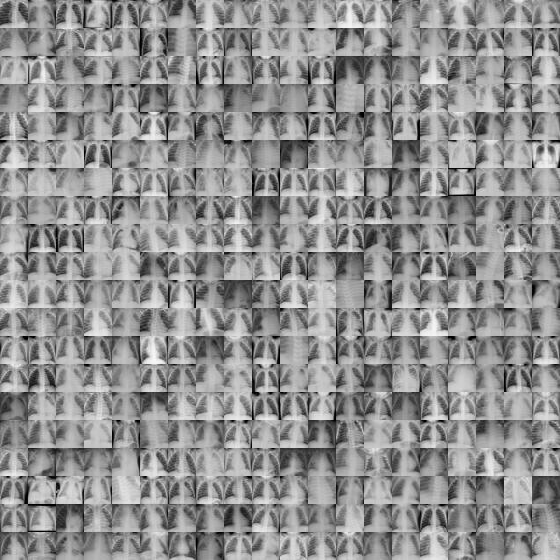

In [472]:
# montage
train_dataset.montage(length=20)

In [473]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [474]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 148/148 [00:01<00:00, 75.51it/s]


In [475]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.991  acc:0.958
test  auc: 0.945  acc:0.819


In [476]:
# Save the state of the model to a file called model.pth
torch.save(model.state_dict(), "../data-kernel-model-rbf/model.pth")

In [477]:
import torch
import torch.nn as nn
import torchvision.models as models

EMBEDDING_LEN=8
# Load the pretrained model
model = Net(in_channels=n_channels, num_classes=n_classes)  # Recreate the model architecture
model.load_state_dict(torch.load("../data-kernel-model-rbf/model.pth", map_location=torch.device('cpu')))

# Add a new dense layer with output size EMBEDDING_LEN
num_ftrs = model.fc._modules['4'].in_features
model.fc._modules['4'] = nn.Linear(num_ftrs, EMBEDDING_LEN)

# Set the model to evaluation mode
model.eval()

# Generate numerical features from a new dataset
def generate_features(dataloader):
    features = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to('cpu')  # Ensure images are on CPU
            output = model(images)
            features.append(output.detach().numpy())
    return features

# Example usage with a dataloader
train_features = generate_features(train_loader)
test_features = generate_features(test_loader)

In [478]:
print(len(train_features))
print(len(train_features[0]))

print(len(test_features))
print(len(test_features[0]))

148
32
10
64


In [479]:
x_train = np.concatenate(train_features, axis=0)
t1 = [targets.numpy() for images, targets in train_loader]
y_train = np.concatenate(t1, axis=0)

x_test = np.concatenate(test_features, axis=0)
t2 = [targets.numpy() for images, targets in test_loader]
y_test = np.concatenate(t2, axis=0)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
#(, y_train), (x_test, y_test)

(4708, 8)
(4708, 1)
(624, 8)
(624, 1)


In [480]:
print(x_train[0])
print(x_train[1])
print(y_train[0])
print(y_train[1])

# for batch in test_loader:
#     # Assuming the first element of the batch contains images
#     images, target = batch  # Discard targets if not needed
#     first_sample = target  # Access the first image
#     print(first_sample)
#     break  # Exit after printing the first sample

[-0.17554203  0.04136167 -0.58374524  0.6556425   0.5204253   1.0383639
  0.06721853 -0.00694406]
[-3.3855438e-04  1.9421369e-01 -4.1185275e-01  4.4939139e-01
  2.8417802e-01  6.0010725e-01  5.1042363e-02 -1.6558492e-01]
[1]
[0]


In [481]:
# Use MinMaxScaler from scikit-learn
from sklearn.preprocessing import MinMaxScaler

# Create a scaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data (only using x_train)
scaler.fit(x_train)

# Transform both training and test data
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train = x_train_scaled
x_test = x_test_scaled

In [482]:
import numpy as np
from sklearn.svm import SVC

In [483]:
# Create an SVM classifier with a suitable kernel
clf = SVC(kernel='rbf', C=1.0, gamma='auto')  # RBF kernel often works well

In [484]:
# Fit the classifier on the training data
y_train = y_train.ravel()
clf.fit(x_train, y_train)

SVC(gamma='auto')

In [485]:
# Make predictions on the test data
y_pred = clf.predict(x_test)

In [486]:
# Evaluate model performance
# y_test = y_test.ravel()
accuracy = clf.score(x_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.625


In [487]:
print(y_test)
print(y_pred)

[[1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/home/caesar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/caesar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/caesar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


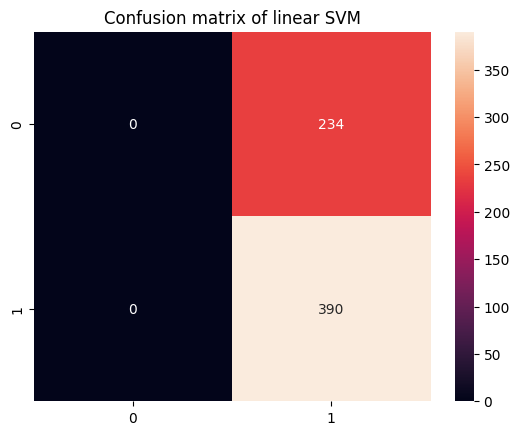

In [488]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix of linear SVM') # fmt='d' formats the numbers as digits, which means integers

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1214
           1       0.74      1.00      0.85      3494

    accuracy                           0.74      4708
   macro avg       0.37      0.50      0.43      4708
weighted avg       0.55      0.74      0.63      4708



/home/caesar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/caesar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/caesar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


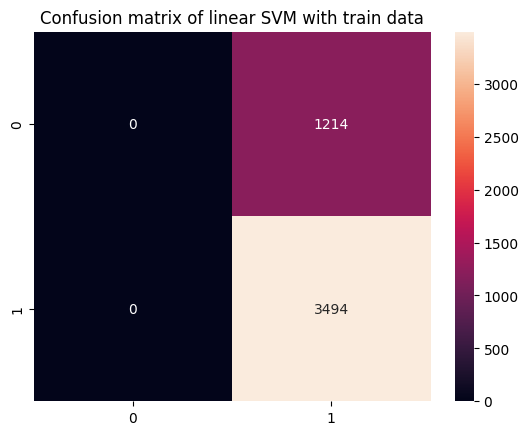

In [489]:
y_pred_train = clf.predict(x_train)

cm_train = confusion_matrix(y_train,y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d').set_title('Confusion matrix of linear SVM with train data')

print(classification_report(y_train,y_pred_train))

In [490]:
clf.get_params()
print(clf.n_support_)

[1214 1456]


In [491]:
# get the actual output of SVM
decision_function = clf.decision_function(x_test)
print(decision_function)

[0.99979043 1.00030034 1.00036867 0.99999825 0.99964565 0.99965232
 0.99989859 0.99963668 1.00034011 1.00030792 0.99966893 0.99981808
 0.99993911 0.99969573 1.00027688 1.00020474 0.99966147 1.000195
 0.99976691 1.000074   0.99992163 0.99977379 1.00009214 1.00019248
 1.00012008 0.99999803 0.99959611 0.99990883 1.00004305 0.99976635
 1.00011399 1.00021207 0.99964269 0.99993688 0.99972672 1.00010074
 0.99983584 1.00029715 1.00008997 1.00015366 0.99971113 1.00001976
 1.00002676 1.00034864 1.00024941 0.99976289 0.99996166 0.99979241
 1.00005942 0.99986396 1.000235   0.99998013 0.99993423 0.9997649
 0.99976687 0.9997796  0.999826   1.00021104 1.00019558 0.99984622
 0.99995155 1.00031613 1.00003546 1.00006666 0.99975374 0.99974815
 1.00029933 0.99996699 1.00003    0.99999103 0.99947798 1.0002521
 1.00020919 0.99969519 0.99985339 1.00011131 1.00021138 1.00003323
 1.00000307 0.99977925 0.99973124 0.99987084 0.99958177 0.99990975
 1.00001903 1.00022434 0.99988114 0.99997198 1.00013078 1.0000437


In [492]:
import numpy as np
print("svc.gamma: ", clf._gamma)
print("svc.degree: ", clf.degree)

sv=open("../data-kernel-model-rbf/support_vectors_rbf.txt","w")
dual_coeff=open("../data-kernel-model-rbf/dual_coeff_rbf.txt","w")
intercept=open("../data-kernel-model-rbf/intercept_rbf.txt","w")
xtestSample="../data-kernel-model-rbf/xtest_rbf.txt"
ytestSample="../data-kernel-model-rbf/ytest_rbf.txt"
ytestClassificationScore="../data-kernel-model-rbf/yclassificationscore.txt"
gammaValue="../data-kernel-model-rbf/gamma.txt"

np.savetxt(sv,clf.support_vectors_)
    
np.savetxt(dual_coeff,clf.dual_coef_,delimiter=' ')
np.savetxt(intercept,clf.intercept_,delimiter=' ')

with open(xtestSample, "w") as f1:
    for item in x_test[0]:  # Access the first row directly
        f1.write(str(item) + " ")
        
with open(ytestClassificationScore, "w") as f2:
    f2.write(str(decision_function[0]))
    
with open(ytestSample, "w") as f3:
    f3.write(str(y_test[0]))
    
with open(gammaValue, "w") as f4:
    f4.write(str(clf._gamma))
    
sv.close()
dual_coeff.close()
intercept.close()
f1.close()
f2.close()
f3.close()
f4.close()

svc.gamma:  0.125
svc.degree:  3


In [493]:
print(str(clf._gamma))
print(str(clf.intercept_))

0.125
[0.96528851]


In [494]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(32, 32, 3)) # This is the Size of your Image